# Vehicle Detection And Recognition with OpenVINO™

This tutorial demonstrates how to use two pre-trained models from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo): [vehicle-detection-0200](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/vehicle-detection-0200) for object detection and [vehicle-attributes-recognition-barrier-0039](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/vehicle-attributes-recognition-barrier-0039) for image classification. Using these models, you will detect vehicles from raw images and recognize attributes of detected vehicles.
![flowchart](https://user-images.githubusercontent.com/47499836/157867076-9e997781-f9ef-45f6-9a51-b515bbf41048.png)

As a result, you can get:

![result](https://user-images.githubusercontent.com/47499836/157867020-99738b30-62ca-44e2-8d9e-caf13fb724ed.png)


#### Table of contents:

- [Imports](#Imports)
- [Download Models](#Download-Models)
- [Load Models](#Load-Models)
    - [Get attributes from model](#Get-attributes-from-model)
    - [Helper function](#Helper-function)
    - [Read and display a test image](#Read-and-display-a-test-image)
- [Use the Detection Model to Detect Vehicles](#Use-the-Detection-Model-to-Detect-Vehicles)
    - [Detection Processing](#Detection-Processing)
    - [Recognize vehicle attributes](#Recognize-vehicle-attributes)
        - [Recognition processing](#Recognition-processing)
    - [Combine two models](#Combine-two-models)



## Imports
[back to top ⬆️](#Table-of-contents:)

Import the required modules.

In [1]:
import platform

%pip install -q "openvino>=2023.1.0" opencv-python tqdm

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import openvino as ov
from typing import Tuple

## Download Models
[back to top ⬆️](#Table-of-contents:)

Download pretrained models from https://storage.openvinotoolkit.org/repositories/open_model_zoo. If the model is already downloaded, this step is skipped.

> **Note**: To change the model, replace the name of the model in the code below, for example to `"vehicle-detection-0201"` or `"vehicle-detection-0202"`. Keep in mind that they support different image input sizes in detection. Also, you can change the recognition model to `"vehicle-attributes-recognition-barrier-0042"`. They are trained from different deep learning frames. Therefore, if you want to change the precision, you need to modify the precision value in `"FP32"`, `"FP16"`, and `"FP16-INT8"`. A different type has a different model size and a precision value.

## Load Models
[back to top ⬆️](#Table-of-contents:)

This tutorial requires a detection model and a recognition model. After downloading the models, initialize OpenVINO Runtime, and use `read_model()` to read network architecture and weights from `*.xml` and `*.bin` files. Then, compile it with `compile_model()` to the specified device.

In [2]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [3]:
# Initialize OpenVINO Runtime runtime.
core = ov.Core()


def model_init() -> Tuple:
    """
    Read the network and weights from file, load the
    model on the CPU and get input and output names of nodes

    :param: model: model architecture path *.xml
    :retuns:
            input_key: Input node network
            output_key: Output node network
            exec_net: Encoder model network
            net: Model network
    """

    # Read the network and corresponding weights from a file.
    model = core.read_model(model="vehicle-detection-0200.xml")
    compiled_model = core.compile_model(model=model, device_name=device.value)
    # Get input and output names of nodes.
    input_keys = compiled_model.input(0)
    output_keys = compiled_model.output(0)
    return input_keys, output_keys, compiled_model
def model_init2() -> Tuple:
    """
    Read the network and weights from file, load the
    model on the CPU and get input and output names of nodes

    :param: model: model architecture path *.xml
    :retuns:
            input_key: Input node network
            output_key: Output node network
            exec_net: Encoder model network
            net: Model network
    """

    # Read the network and corresponding weights from a file.
    model = core.read_model(model="vehicle-attributes-recognition-barrier-0039.xml")
    compiled_model = core.compile_model(model=model, device_name=device.value)
    # Get input and output names of nodes.
    input_keys = compiled_model.input(0)
    output_keys = compiled_model.output(0)
    return input_keys, output_keys, compiled_model

### Get attributes from model
[back to top ⬆️](#Table-of-contents:)

Use `input_keys.shape` to get data shapes.

In [4]:
# de -> detection
# re -> recognition
# Detection model initialization.
input_key_de, output_keys_de, compiled_model_de = model_init()
# Recognition model initialization.
input_key_re, output_keys_re, compiled_model_re = model_init2()

# Get input size - Detection.
height_de, width_de = list(input_key_de.shape)[2:]
# Get input size - Recognition.
height_re, width_re = list(input_key_re.shape)[2:]
print(height_re, width_re)

72 72


### Helper function
[back to top ⬆️](#Table-of-contents:)

The `plt_show()` function is used to show image.

In [5]:
def plt_show(raw_image):
    """
    Use matplot to show image inline
    raw_image: input image

    :param: raw_image:image array
    """
    plt.figure(figsize=(10, 6))
    plt.axis("off")
    plt.imshow(raw_image)

### Read and display a test image
[back to top ⬆️](#Table-of-contents:)

The input shape of detection model is `[1, 3, 256, 256]`. Therefore, you need to resize the image to `256 x 256`, and expand the batch channel with `expand_dims` function.

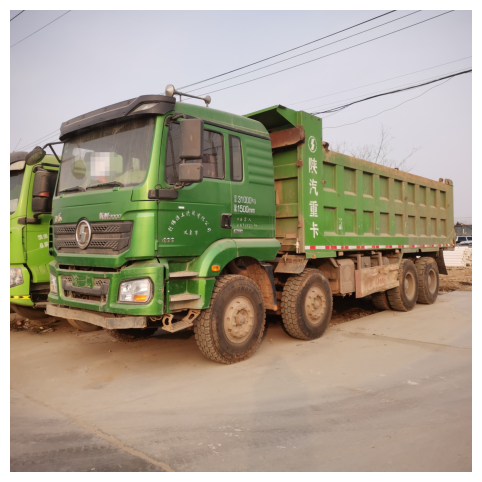

In [6]:
# Load an image.


# Read the image.
image_de = cv2.imread("00.jpg")
# Resize it to [3, 256, 256].
resized_image_de = cv2.resize(image_de, (width_de, height_de))
# Expand the batch channel to [1, 3, 256, 256].
input_image_de = np.expand_dims(resized_image_de.transpose(2, 0, 1), 0)
# Show the image.
plt_show(cv2.cvtColor(image_de, cv2.COLOR_BGR2RGB))

## Use the Detection Model to Detect Vehicles
[back to top ⬆️](#Table-of-contents:)

![pipline](https://user-images.githubusercontent.com/47499836/157867076-9e997781-f9ef-45f6-9a51-b515bbf41048.png)

As shown in the flowchart, images of individual vehicles are sent to the recognition model. First, use `infer` function to get the result.

The detection model output has the format `[image_id, label, conf, x_min, y_min, x_max, y_max]`, where:

- `image_id` - ID of the image in the batch
- `label` - predicted class ID (0 - vehicle)
- `conf` - confidence for the predicted class
- `(x_min, y_min)` - coordinates of the top left bounding box corner
- `(x_max, y_max)` - coordinates of the bottom right bounding box corner

Delete unused dims and filter out results that are not used.

In [7]:
# Run inference.
boxes = compiled_model_de([input_image_de])[output_keys_de]
# Delete the dim of 0, 1.
boxes = np.squeeze(boxes, (0, 1))
# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

### Detection Processing
[back to top ⬆️](#Table-of-contents:)

With the function below, you change the ratio to the real position in the image and filter out low-confidence results.

In [8]:
def crop_images(bgr_image, resized_image, boxes, threshold=0.6) -> np.ndarray:
    """
    Use bounding boxes from detection model to find the absolute car position

    :param: bgr_image: raw image
    :param: resized_image: resized image
    :param: boxes: detection model returns rectangle position
    :param: threshold: confidence threshold
    :returns: car_position: car's absolute position
    """
    # Fetch image shapes to calculate ratio
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],
        resized_image.shape[:2],
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Find the boxes ratio
    boxes = boxes[:, 2:]
    # Store the vehicle's position
    car_position = []
    # Iterate through non-zero boxes
    for box in boxes:
        # Pick confidence factor from last place in array
        conf = box[0]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio
            # In case that bounding box is found at the top of the image,
            # upper box  bar should be positioned a little bit lower to make it visible on image
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y * resized_y, 10)) if idx % 2 else int(corner_position * ratio_x * resized_x))
                for idx, corner_position in enumerate(box[1:])
            ]

            car_position.append([x_min, y_min, x_max, y_max])

    return car_position

In [10]:
# Find the position of a car.
car_position = crop_images(image_de, resized_image_de, boxes)

### Recognize vehicle attributes
[back to top ⬆️](#Table-of-contents:)

Select one of the detected boxes. Then, crop to an area containing a vehicle to test with the recognition model. Again, you need to resize the input image and run inference.

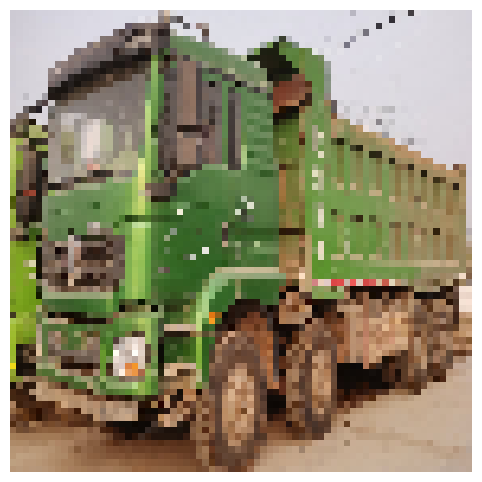

In [11]:
# Select a vehicle to recognize.
pos = car_position[0]
# Crop the image with [y_min:y_max, x_min:x_max].
test_car = image_de[pos[1] : pos[3], pos[0] : pos[2]]
# Resize the image to input_size.
resized_image_re = cv2.resize(test_car, (width_re, height_re))
input_image_re = np.expand_dims(resized_image_re.transpose(2, 0, 1), 0)
plt_show(cv2.cvtColor(resized_image_re, cv2.COLOR_BGR2RGB))

##### Recognition processing
[back to top ⬆️](#Table-of-contents:)

The result contains colors of the vehicles (white, gray, yellow, red, green, blue, black) and types of vehicles (car, bus, truck, van). Next, you need to calculate the probability of each attribute. Then, you determine the maximum probability as the result.

In [12]:
def vehicle_recognition(compiled_model_re, input_size, raw_image):
    """
    Vehicle attributes recognition, input a single vehicle, return attributes
    :param: compiled_model_re: recognition net
    :param: input_size: recognition input size
    :param: raw_image: single vehicle image
    :returns: attr_color: predicted color
                       attr_type: predicted type
    """
    # An attribute of a vehicle.
    colors = ["White", "Gray", "Yellow", "Red", "Green", "Blue", "Black"]
    types = ["Car", "Bus", "Truck", "Van"]

    # Resize the image to input size.
    resized_image_re = cv2.resize(raw_image, input_size)
    input_image_re = np.expand_dims(resized_image_re.transpose(2, 0, 1), 0)

    # Run inference.
    # Predict result.
    predict_colors = compiled_model_re([input_image_re])[compiled_model_re.output(1)]
    # Delete the dim of 2, 3.
    predict_colors = np.squeeze(predict_colors, (2, 3))
    predict_types = compiled_model_re([input_image_re])[compiled_model_re.output(0)]
    predict_types = np.squeeze(predict_types, (2, 3))

    attr_color, attr_type = (
        colors[np.argmax(predict_colors)],
        types[np.argmax(predict_types)],
    )
    return attr_color, attr_type

In [13]:
print(f"Attributes:{vehicle_recognition(compiled_model_re, (72, 72), test_car)}")

Attributes:('Green', 'Truck')


### Combine two models
[back to top ⬆️](#Table-of-contents:)

Congratulations! You successfully used a detection model to crop an image with a vehicle and recognize the attributes of a vehicle.

In [14]:
def convert_result_to_image(compiled_model_re, bgr_image, resized_image, boxes, threshold=0.6):
    """
    Use Detection model boxes to draw rectangles and plot the result

    :param: compiled_model_re: recognition net
    :param: input_key_re: recognition input key
    :param: bgr_image: raw image
    :param: resized_image: resized image
    :param: boxes: detection model returns rectangle position
    :param: threshold: confidence threshold
    :returns: rgb_image: processed image
    """
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Find positions of cars.
    car_position = crop_images(image_de, resized_image, boxes)

    for x_min, y_min, x_max, y_max in car_position:
        # Run vehicle recognition inference.
        attr_color, attr_type = vehicle_recognition(compiled_model_re, (72, 72), image_de[y_min:y_max, x_min:x_max])

        # Close the window with a vehicle.
        plt.close()

        # Draw a bounding box based on position.
        # Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
        rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["red"], 2)

        # Print the attributes of a vehicle.
        # Parameters in the `putText` function are: img, text, org, fontFace, fontScale, color, thickness, lineType.
        rgb_image = cv2.putText(
            rgb_image,
            f"{attr_color} {attr_type}",
            (x_min, y_min - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            2,
            colors["green"],
            10,
            cv2.LINE_AA,
        )

    return rgb_image

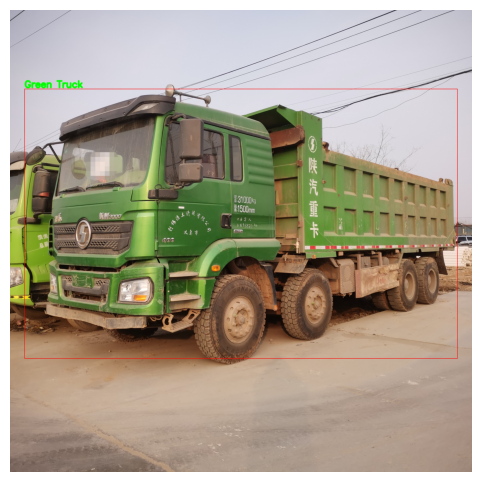

In [15]:
plt_show(convert_result_to_image(compiled_model_re, image_de, resized_image_de, boxes))